# **Exploratory Data Analysis**

In [1]:
!pip install livelossplot --quiet

import os
import math
from random import randint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

from keras.layers.experimental.preprocessing import Normalization
from keras import Input
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.utils import plot_model

import tensorflow as tf
from tensorflow import keras

import h5py
from tqdm import tqdm
from livelossplot import PlotLossesKeras
from IPython.display import Image
import matplotlib.cm as cma
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/MURA-v1.1.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/XR_WRIST/patient08489/study1_negative/image3.png  
  inflating: train/XR_WRIST/patient08489/study1_negative/image4.png  
  inflating: train/XR_WRIST/patient08490/study1_negative/image1.png  
  inflating: train/XR_WRIST/patient08490/study1_negative/image2.png  
  inflating: train/XR_WRIST/patient08490/study1_negative/image3.png  
  inflating: train/XR_WRIST/patient08491/study1_negative/image1.png  
  inflating: train/XR_WRIST/patient08491/study1_negative/image2.png  
  inflating: train/XR_WRIST/patient08492/study1_negative/image1.png  
  inflating: train/XR_WRIST/patient08492/study1_negative/image2.png  
  inflating: train/XR_WRIST/patient08493/study1_negative/image1.png  
  inflating: train/XR_WRIST/patient08493/study1_negative/image2.png  
  inflating: train/XR_WRIST/patient08493/study1_negative/image3.png  
  inflating: train/XR_WRIST/patient08494/study1_negative/image1.png  
  inflating: train/XR_WRIST/patient0849

In [4]:
data_dir = "/content/"
csv_dir = "/content/MURA-v1.1/"
checkpoint_log_plot_dir = "/content/drive/MyDrive/Colab Notebooks/check-points"

Load CSV File

In [6]:
train_csv = 'train_image_paths.csv'
validation_csv = 'valid_image_paths.csv'

df_train_EDA = pd.read_csv(csv_dir+train_csv,names=["path","label"])
df_train_EDA.label = df_train_EDA.label.apply(str)

df_validation_EDA = pd.read_csv(csv_dir+validation_csv,names=["path","label"])
df_validation_EDA.label = df_validation_EDA.label.apply(str)


# label it based on the directory name for train and validation file
df_train_EDA['label'] = df_train_EDA['path'].apply(lambda x: '1' if 'positive' in x else '0')
df_validation_EDA['label'] = df_validation_EDA['path'].apply(lambda x: '1' if 'positive' in x else '0')

Checkout the shape of dataset

In [7]:
df_train_EDA.shape, df_validation_EDA.shape

((36808, 2), (3197, 2))

We have 36808 x-ray images in the train dataset and 3197 x-ray images in validaiton dataaset

In [8]:
df_train_EDA.head()

path label
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...     1
1  MURA-v1.1/train/XR_SHOULDER/patient00001/study...     1
2  MURA-v1.1/train/XR_SHOULDER/patient00001/study...     1
3  MURA-v1.1/train/XR_SHOULDER/patient00002/study...     1
4  MURA-v1.1/train/XR_SHOULDER/patient00002/study...     1

In [9]:
df_validation_EDA.head()

path label
0  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...     1
1  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...     1
2  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...     1
3  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...     1
4  MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...     1

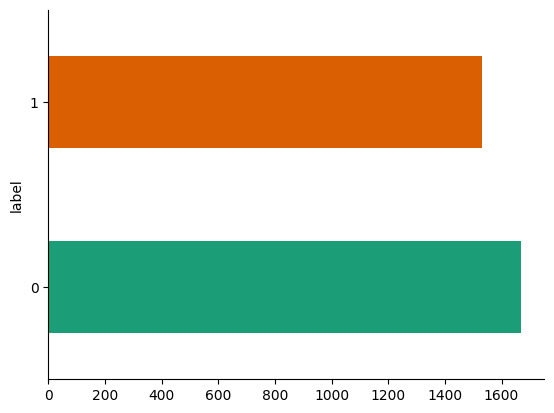

In [10]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
df_validation_EDA.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [11]:
# Define categories of data
data_phases = ['train', 'valid']
# Obtain the types of studies from the train directory structure
list_of_study_types = os.listdir('/content/MURA-v1.1/valid/')

print(list_of_study_types)

# Initialize a dictionary to store the count of patients across train and valid data sets
study_patient_counts = {}

# Iterate over each data phase (train or valid)
for phase in data_phases:
    study_patient_counts[phase] = {}
    for study in list_of_study_types:
        # Build the path for each study type within the current data phase
        study_path = f'/content/MURA-v1.1/{phase}/{study}'
        print(study_path)
        # Retrieve patient folder names in the current study type path
        patient_folders = os.listdir(study_path)
        # Calculate and store the number of patient folders
        study_patient_counts[phase][study] = len(patient_folders)

# Display the types of studies and patient counts across both data phases


['XR_HAND', 'XR_WRIST', 'XR_ELBOW', 'XR_HUMERUS', 'XR_FINGER', 'XR_SHOULDER', 'XR_FOREARM']
/content/MURA-v1.1/train/XR_HAND
/content/MURA-v1.1/train/XR_WRIST
/content/MURA-v1.1/train/XR_ELBOW
/content/MURA-v1.1/train/XR_HUMERUS
/content/MURA-v1.1/train/XR_FINGER
/content/MURA-v1.1/train/XR_SHOULDER
/content/MURA-v1.1/train/XR_FOREARM
/content/MURA-v1.1/valid/XR_HAND
/content/MURA-v1.1/valid/XR_WRIST
/content/MURA-v1.1/valid/XR_ELBOW
/content/MURA-v1.1/valid/XR_HUMERUS
/content/MURA-v1.1/valid/XR_FINGER
/content/MURA-v1.1/valid/XR_SHOULDER
/content/MURA-v1.1/valid/XR_FOREARM


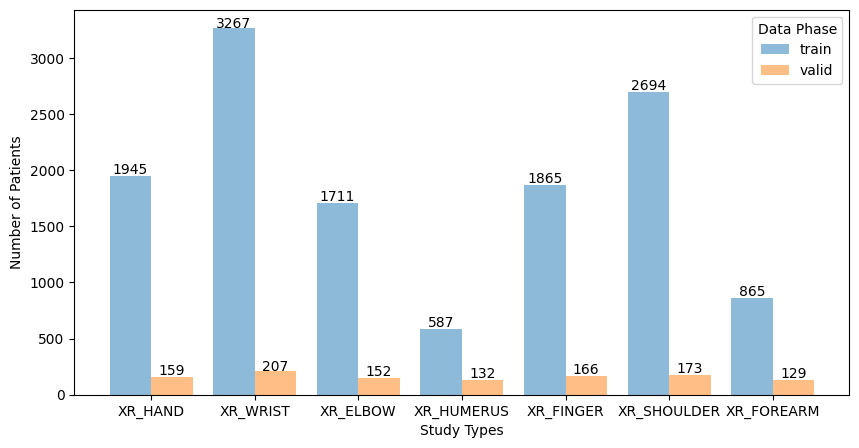

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize a figure and axes object with size specifications
fig, ax = plt.subplots(figsize=(10, 5))

# Define offsets for text annotations for maximum and other values
max_text_offset = 3
other_text_offset = 20

# Process each phase and plot bars
for index, phase in enumerate(data_phases):
    patient_counts = list(study_patient_counts[phase].values())
    max_count = max(patient_counts)

    # Generate positions for each bar
    positions = np.arange(len(list_of_study_types)) + index * 0.4  # Slight offset to side by side bars

    # Plotting the bar for current phase
    bars = ax.bar(positions, patient_counts, alpha=0.5, label=phase, width=0.4)

    # Adding text labels above bars
    for bar in bars:
        yval = bar.get_height()
        if yval == max_count:
            ax.text(bar.get_x() + bar.get_width()/2, yval + max_text_offset, str(yval), ha='center')
        else:
            ax.text(bar.get_x() + bar.get_width()/2, yval + other_text_offset, str(yval), ha='center')

# Set x-axis labels and ticks
ax.set_xticks(np.arange(len(list_of_study_types)) + 0.4 / 2)
ax.set_xticklabels(list_of_study_types)
ax.set_xlabel('Study Types')
ax.set_ylabel('Number of Patients')

# Add legend to the plot
plt.legend(title="Data Phase")

# Display the plot
plt.show()

# Save the figure
fig.savefig('/content/drive/MyDrive/pcpst.jpg', bbox_inches='tight', pad_inches=0)


### **Building CNN**

In this Project, I focus on the XR_HUMERUS dataset for training. We filter our dataset to include only data pertaining to this specific study type, ensuring that our model training is targeted and relevant to XR_HUMERUS cases.

In [13]:
from sklearn.model_selection import train_test_split
study_type = "XR_HUMERUS"

# load the train data
df_train_total = pd.read_csv(csv_dir+train_csv,names=["path","label"])
# Filter rows that contain "study_type" in the path
df_train_total = df_train_total[df_train_total['path'].str.contains(study_type)]
# Assign labels: 1 if 'positive' is in the path, 0 otherwise
df_train_total['label'] = df_train_total['path'].apply(lambda x: '1' if 'positive' in x else '0')

# load the validation data
df_validation = pd.read_csv(csv_dir+validation_csv,names=["path","label"])
# Filter rows that contain "study_type" in the path
df_validation = df_validation[df_validation['path'].str.contains(study_type)]

# Assign labels: 1 if 'positive' is in the path, 0 otherwise
df_validation['label'] = df_validation['path'].apply(lambda x: '1' if 'positive' in x else '0')


df_train, df_test = train_test_split(df_train_total, test_size=0.05, random_state=42)

df_train.head()

path label
9304  MURA-v1.1/train/XR_HUMERUS/patient03067/study1...     0
8977  MURA-v1.1/train/XR_HUMERUS/patient02937/study1...     1
8547  MURA-v1.1/train/XR_HUMERUS/patient02763/study1...     1
9195  MURA-v1.1/train/XR_HUMERUS/patient00631/study1...     0
8906  MURA-v1.1/train/XR_HUMERUS/patient02910/study1...     1

In [14]:
df_test.head()

path label
8587  MURA-v1.1/train/XR_HUMERUS/patient02778/study1...     1
9345  MURA-v1.1/train/XR_HUMERUS/patient03086/study1...     0
9093  MURA-v1.1/train/XR_HUMERUS/patient02991/study1...     0
9571  MURA-v1.1/train/XR_HUMERUS/patient03188/study1...     0
8963  MURA-v1.1/train/XR_HUMERUS/patient02932/study1...     1

In [15]:
df_train_total.shape

(1272, 2)

In [16]:
# Standardize image by normalizing pixel values
def standardize(image):
  mean = 52.47950723124079
  std = 68.79819863188669
  image = (image-mean)/std
  return image


demonstratation of standardization effect

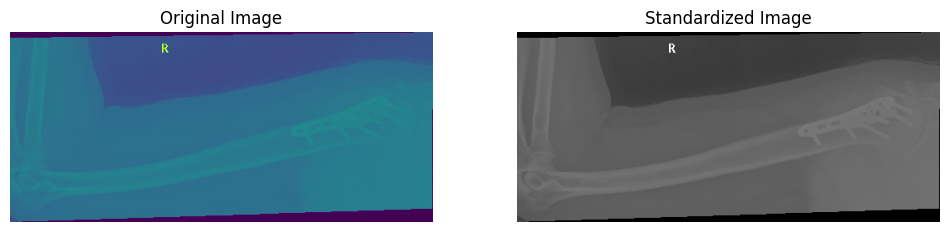

Original Image Values:
[[ 0.  0.  0. ... 67. 68. 67.]
 [ 0.  0.  0. ... 68. 67. 67.]
 [ 0.  0.  0. ... 66. 67. 67.]
 ...
 [64. 65. 66. ...  0.  0.  0.]
 [66. 66. 64. ...  0.  0.  0.]
 [65. 64. 65. ...  0.  0.  0.]]

Standardized Image Values:
[[-0.76280351 -0.76280351 -0.76280351 ...  0.2110592   0.22559446
   0.2110592 ]
 [-0.76280351 -0.76280351 -0.76280351 ...  0.22559446  0.2110592
   0.2110592 ]
 [-0.76280351 -0.76280351 -0.76280351 ...  0.19652394  0.2110592
   0.2110592 ]
 ...
 [ 0.16745341  0.18198867  0.19652394 ... -0.76280351 -0.76280351
  -0.76280351]
 [ 0.19652394  0.19652394  0.16745341 ... -0.76280351 -0.76280351
  -0.76280351]
 [ 0.18198867  0.16745341  0.18198867 ... -0.76280351 -0.76280351
  -0.76280351]]


In [17]:
from PIL import Image

# Load an image from the dataset
file_path = '/content/MURA-v1.1/train/XR_HUMERUS/patient00051/study1_positive/image1.png'  # Change this to the path of your image
image = Image.open(file_path)
image = np.array(image, dtype=float)  # Convert to float to allow proper division

# Display the original image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image.astype(np.uint8))  # Convert back to uint8 for displaying
plt.title('Original Image')
plt.axis('off')

# Apply standardization
standardized_image = standardize(image)

# Display standardized image values
plt.subplot(1, 2, 2)
plt.imshow(standardized_image, cmap='gray')  # Use gray colormap for better clarity
plt.title('Standardized Image')
plt.axis('off')

plt.show()

# Optionally, print pixel values to console
print("Original Image Values:")
print(image)

print("\nStandardized Image Values:")
print(standardized_image)

Define All Hyper parametes for model

In [18]:
# Configure model training settings and parameters including image processing dimensions, batch sizes, and augmentation techniques. Define the learning algorithm specifics such as optimizer, learning rate, loss function, and metrics. Initialize visualization and saving callbacks to monitor training progress and log performance data, ensuring best models are saved based on validation loss.

model_id = "05"

image_height, image_width = 256, 256

train_batch_size, validation_batch_size = 64, 64

rotation_range = 30
image_brightness_range = [0.8,1.2]

preprocessing_function = standardize

lr = 0.0001
opt=  Adam(learning_rate=lr)
loss='binary_crossentropy'
metrics=['acc']
epochs = 85
dropout_rate = 0.3


plotlosses = PlotLossesKeras()
training_callbacks = [ plotlosses,
                ModelCheckpoint(checkpoint_log_plot_dir+model_id+".h5", monitor = "val_loss", save_best_only=True, mode="auto",options=None),
                keras.callbacks.CSVLogger(filename = checkpoint_log_plot_dir + model_id+".csv")
                ]

In [19]:
# Load and preprocess images from a DataFrame, resizing them and converting to arrays for model training, returning a dictionary of images and labels.
def ImagesToArrayConversion(df,imgh,imgw):
    images = []
    labels = []
    for index, data in (df.iterrows()):
      img = tf.keras.preprocessing.image.load_img(data_dir+data['path'],color_mode='rgb',target_size=(imgh,imgw))
      img = keras.preprocessing.image.img_to_array(img,dtype="float32")
      images.append(img)
      labels.append(data['label'])
    images = np.asarray(images)
    labels = np.asarray(labels)
    return {'images': images, 'labels': labels}

In [20]:
from keras.layers import Input, ZeroPadding2D, Dropout, concatenate, Reshape, Activation, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D

# Axis for batch normalization, typically 3 for channels_last data format
norm_axis = 3

def apply_conv2d_with_bn(tensor, num_filters, kernel_height, kernel_width, use_padding='same', stride_length=(1, 1), layer_name=None):
    """
    Apply a Conv2D followed by BatchNormalization and a ReLU activation to the input tensor.
    """
    # Construct names for the convolution and batch normalization layers if a base layer name is provided
    bn_layer_name = f"{layer_name}_bn" if layer_name else None
    conv_layer_name = f"{layer_name}_conv" if layer_name else None

    # Conv2D layer without bias as it's followed by BatchNormalization
    tensor = Conv2D(
        num_filters, (kernel_height, kernel_width),
        strides=stride_length,
        padding=use_padding,
        use_bias=False,
        name=conv_layer_name
    )(tensor)

    # Batch normalization layer
    tensor = BatchNormalization(axis=norm_axis, scale=False, name=bn_layer_name)(tensor)

    # Activation layer using ReLU
    tensor = Activation('relu', name=layer_name)(tensor)

    return tensor


In [21]:
from keras.layers import Dense, Dropout

def apply_dense_with_dropout(tensor, units, dropout_rate, layer_name=None):
    """
    Apply a Dense layer followed by Dropout to the input tensor.

    Args:
    tensor (tensor): Input tensor to the Dense layer.
    units (int): Number of neurons in the Dense layer.
    dropout_rate (float): Dropout rate between 0 and 1.
    layer_name (str, optional): Base name for the layers. If provided, the Dense and Dropout layers will be named.

    Returns:
    tensor: Output tensor after applying the Dense and Dropout layers.
    """
    # Dense layer
    dense_layer_name = f"{layer_name}_dense" if layer_name else None
    tensor = Dense(units, activation='relu', name=dense_layer_name)(tensor)

    # Dropout layer
    dropout_layer_name = f"{layer_name}_dropout" if layer_name else None
    tensor = Dropout(dropout_rate, name=dropout_layer_name)(tensor)

    return tensor

**Data augmentation for train and validation dataset**

In [22]:
# Set up image data augmentation parameters for training data to enhance model generalizability.
train_gen = ImageDataGenerator(rotation_range=rotation_range, brightness_range=image_brightness_range, horizontal_flip=True, fill_mode="constant", cval=0.0, preprocessing_function=preprocessing_function)

# Initialize a simpler generator for validation data without augmentation, only preprocessing.
valid_gen = ImageDataGenerator(preprocessing_function=preprocessing_function)

# Create iterators over the training and validation datasets to efficiently load and preprocess batches of images as specified.
train_iter = train_gen.flow_from_dataframe(df_train, directory=data_dir, x_col="path", y_col="label", target_size=(image_height, image_width), color_mode="rgb", class_mode="binary", batch_size=train_batch_size, shuffle=True)
valid_iter = valid_gen.flow_from_dataframe(df_validation, directory=data_dir, x_col="path", y_col="label", target_size=(image_height, image_width), color_mode="rgb", class_mode="binary", batch_size=validation_batch_size, shuffle=True)


Found 1208 validated image filenames belonging to 2 classes.
Found 288 validated image filenames belonging to 2 classes.


In [23]:
print('Training samples:', train_iter.samples)
print('Validation samples:', valid_iter.samples)

Training samples: 1208
Validation samples: 288


**Model Creation**

In [24]:

def define_model():
    input_tensor = Input(shape=(image_height, image_width, 3))

    x = apply_conv2d_with_bn(input_tensor, 32, 3, 3, use_padding="valid")
    x = apply_conv2d_with_bn(x, 64, 3, 3, use_padding="valid")
    x = apply_conv2d_with_bn(x, 64, 3, 3, use_padding="valid")
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = apply_conv2d_with_bn(x, 64, 3, 3, use_padding="valid")
    x = apply_conv2d_with_bn(x, 128, 3, 3, use_padding="valid")
    x = apply_conv2d_with_bn(x, 128, 3, 3, use_padding="valid")
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = apply_conv2d_with_bn(x, 128, 3, 3, use_padding="valid")
    x = apply_conv2d_with_bn(x, 256, 3, 3, use_padding="valid")
    x = apply_conv2d_with_bn(x, 256, 3, 3, use_padding="valid")
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Global average pooling to reduce the spatial dimensions to a single 256-dimensional vector
    x = GlobalAveragePooling2D()(x)
    # Dropout layer to reduce overfitting by randomly setting a fraction of the inputs to 0
    x = Dropout(dropout_rate)(x)
    # Output layer with a single neuron and sigmoid activation function for binary classification
    predictions = Dense(1, activation='sigmoid', name="final")(x)

    # Create the model object linking input and output
    model = Model(inputs=input_tensor, outputs=predictions)

    return model



**Model Compilation and visulization of its structure**

In [25]:
# Define and compile the model
model = define_model()
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [26]:
# print model summary about its layers and operations
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      864       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      96        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 254, 254, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 64)      18432     
                                                                 
 batch_normalization_1 (Bat  (None, 252, 252, 64)      192       
 chNormalization)                                            

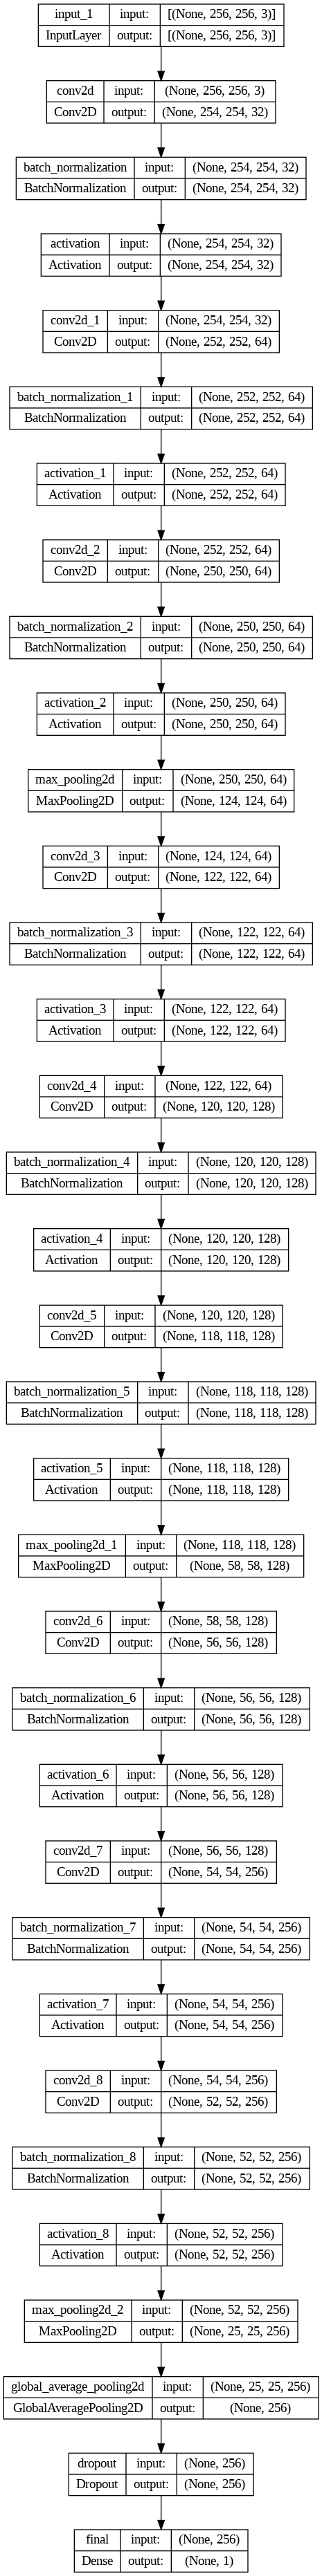

In [27]:
# Visualize and save the model architecture
plot_model(model, to_file= checkpoint_log_plot_dir + model_id + ".png", show_shapes=True)

In [28]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name) +",  tf version: "+str(tf.__version__))

Found GPU at: /device:GPU:0,  tf version: 2.15.0


**Model Training**

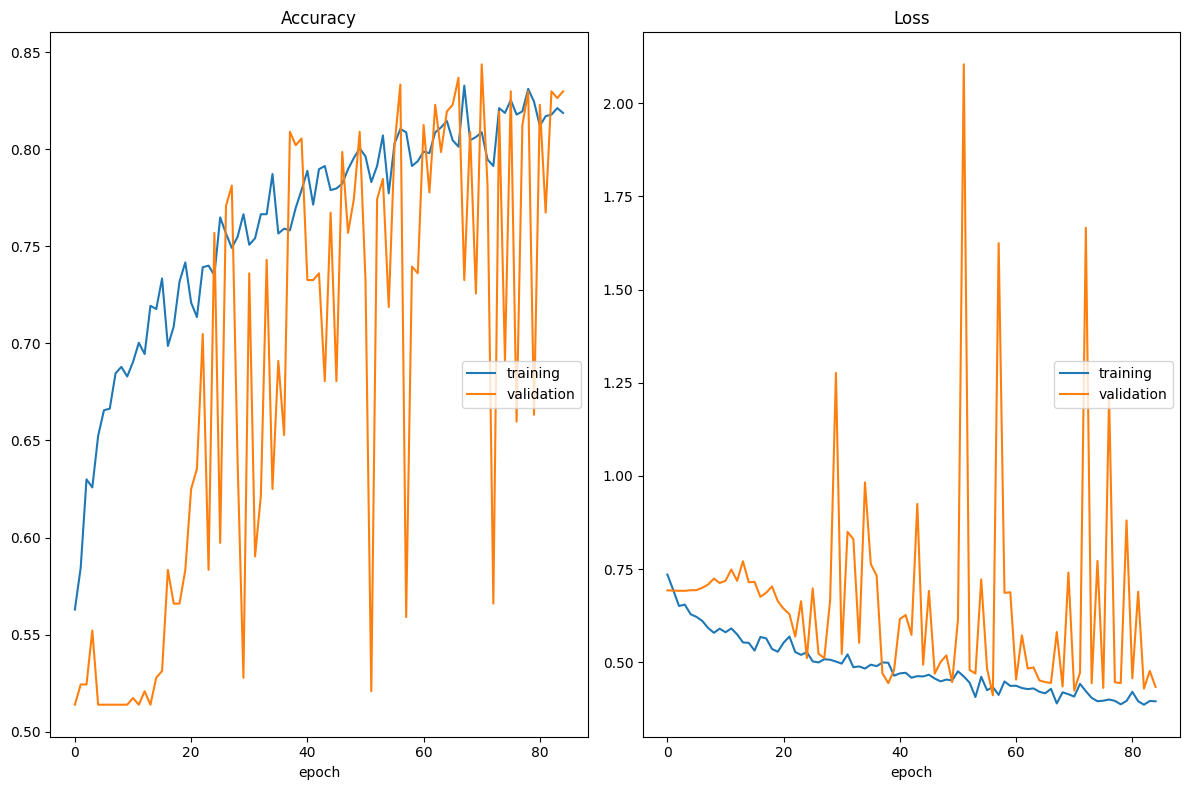

Accuracy
	training         	 (min:    0.563, max:    0.833, cur:    0.819)
	validation       	 (min:    0.514, max:    0.844, cur:    0.830)
Loss
	training         	 (min:    0.386, max:    0.735, cur:    0.395)
	validation       	 (min:    0.412, max:    2.104, cur:    0.434)
19/19 [==============================] - 39s 2s/step - loss: 0.3954 - acc: 0.8187 - val_loss: 0.4338 - val_acc: 0.8299

No. of epochs ran: 85(expected: 85)


In [29]:
history = model.fit(train_iter, epochs= epochs, validation_data = valid_iter, callbacks= training_callbacks, initial_epoch=0)
print("\nNo. of epochs ran: %d(expected: %d)"% (len(history.history["val_loss"]), epochs))

In [30]:
model = load_model(checkpoint_log_plot_dir+model_id+".h5")
log_dict = pd.read_csv(checkpoint_log_plot_dir+model_id+".csv").to_dict(orient = "list")

In [31]:
df_test['label'] = df_test['label'].apply(lambda x: int(x))
df_test.head()

path  label
8587  MURA-v1.1/train/XR_HUMERUS/patient02778/study1...      1
9345  MURA-v1.1/train/XR_HUMERUS/patient03086/study1...      0
9093  MURA-v1.1/train/XR_HUMERUS/patient02991/study1...      0
9571  MURA-v1.1/train/XR_HUMERUS/patient03188/study1...      0
8963  MURA-v1.1/train/XR_HUMERUS/patient02932/study1...      1

In [32]:
test_dict = ImagesToArrayConversion(df_test,image_height,image_width)

if preprocessing_function:
  test_dict["images"] = preprocessing_function(test_dict["images"])
test_dict["images"].shape

(64, 256, 256, 3)

**Model Evaluation**

2/2 [==============================] - 0s 172ms/step
Confusion Matrix:


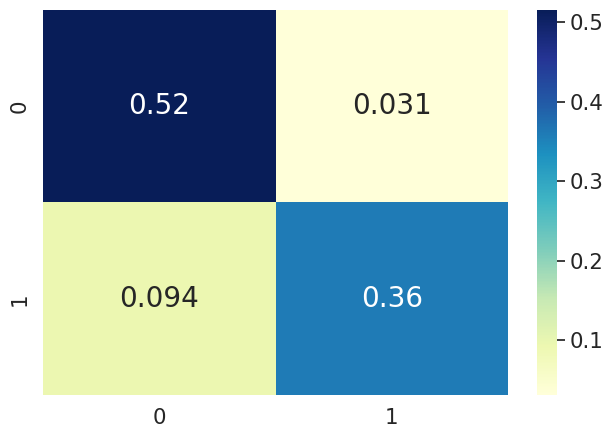

tn: 33      fp: 2      fn: 6      tp: 23
                    XR_HUMERUS
loss                  0.408036
accuracy              0.875000
precision             0.920000
specificity           0.942857
recall/sensitivity    0.793103
f1_score              0.851852
Cohen Kappa score     0.744766
prediction error      0.125000


In [33]:
# Predict probabilities for the test images using the trained model
pred_batch = model.predict(test_dict["images"])

# Initialize an empty list to store binary predictions
pred = []
# Convert probabilities to binary predictions with a threshold of 0.5
for p in pred_batch:
    if p > 0.5:
        pred += [1]
    else:
        pred += [0]

# Compute the confusion matrix with actual and predicted labels
cm = confusion_matrix(test_dict['labels'], pred)  # (y_true, y_pred)
# Extract individual counts for true negatives, false positives, false negatives, and true positives
tn, fp, fn, tp = cm.ravel()
# Recompute the normalized confusion matrix
cm = confusion_matrix(test_dict['labels'], pred, normalize="all")

# Calculate the accuracy of the model
Accuracy = (tp + tn) / (tp + tn + fp + fn)
# Calculate the precision of the model
Precision = tp / (tp + fp)
# Calculate the specificity of the model
Specificity = tn / (tn + fp)
# Calculate the recall (sensitivity) of the model
Recall = tp / (tp + fn)
# Calculate the F1 score of the model
F1_score = (2 * Recall * Precision) / (Recall + Precision)
# Calculate Cohen's Kappa score, a measure of inter-annotator agreement
kap = cohen_kappa_score(test_dict['labels'], pred)
# Calculate the prediction error rate
error = np.sum(np.not_equal(pred, test_dict['labels'])) / test_dict['labels'].shape[0]
# Evaluate the model to get the overall loss on the test set
loss_overall, _ = model.evaluate(test_dict["images"], test_dict["labels"], verbose=0)

# Store all evaluation metrics in a dictionary
eval_dict = {
    "loss": loss_overall,
    "accuracy": Accuracy,
    "precision": Precision,
    "specificity": Specificity,
    "recall/sensitivity": Recall,
    "f1_score": F1_score,
    "Cohen Kappa score": kap,
    "prediction error": error
}

# Prepare column names for the results DataFrame using the study type
eval_df_columns = []
eval_df_columns.append(study_type)

# Create a DataFrame from the dictionary of evaluation metrics
eval_df = pd.DataFrame.from_dict(eval_dict, orient="index", columns=eval_df_columns)

# Output the confusion matrix using seaborn for better visualization
print('Confusion Matrix:')
import seaborn as sn
plt.figure(figsize=(7.5, 5))
sn.set(font_scale=1.4)  # Set font scale for better readability
sn.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap="YlGnBu")  # Create a heatmap
plt.show()
# Print individual counts from the confusion matrix
print("tn:", tn, "     fp:", fp, "     fn:", fn, "     tp:", tp)

# Optionally, display the DataFrame containing all metrics
print(eval_df)

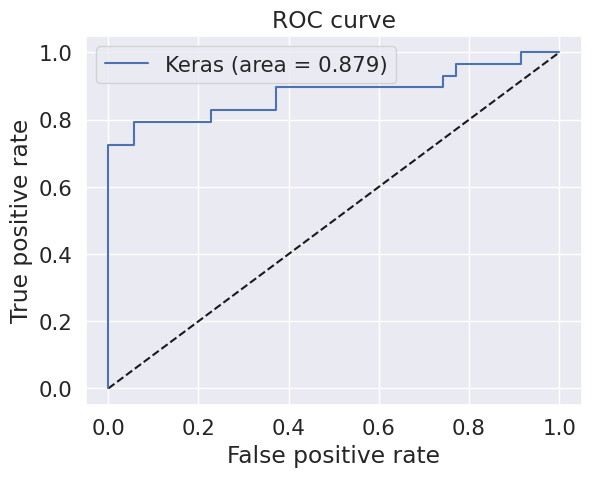

In [34]:
# Calculate the ROC curve and AUC to evaluate the classifier's performance.
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_dict['labels'], pred_batch)
auc_keras = auc(fpr_keras, tpr_keras)

# Plot the complete ROC curve to visualize the overall effectiveness of the model.
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [35]:
# Define a function to create a Grad-CAM heatmap using model predictions, layer activations, and gradients.
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


# Visualize Grad-CAM heatmaps for selected images from a validation dataset.
def grad_cam_vis(valid_csv, study_type, preprocess_fn, model, last_conv_layer_name, classifier_layer_names, number, size_tuple):
  plt.rcParams['figure.figsize'] = (18*2, 6*5)
  for i in range(number):
    # Load and preprocess images, then predict their classes using the model.
    dfv = pd.read_csv(csv_dir+valid_csv,names=["path","label"])
    if study_type:
      dfv = dfv.loc[ dfv.path.apply(lambda x: x[16:-40])== study_type ].reset_index(drop=True)

    rand_num = randint(0,dfv.shape[0]-1)


    img = tf.keras.preprocessing.image.load_img(data_dir + dfv.path[rand_num],color_mode='rgb',target_size= size_tuple)
    img = keras.preprocessing.image.img_to_array(img,dtype="float32")

    #Backup
    imgB = np.copy(img)
    if preprocess_fn:
      img = preprocess_fn(img)
    img = np.expand_dims(img,0)

    predict = None
    preds = model.predict(img)
    if(preds > 0.5):
      predict = 1
    else:
      predict = 0

    # Display original image, heatmap, and superimposed heatmap.
    plt.subplot(number,3,3*i+1).set_title("Actual : "+str(dfv.label[rand_num])+"  ;  Predicted : "+str(predict)+"["+str(preds)+"]"+"/nImg Dir: "+dfv.path[rand_num][-16:-40]+"/"+dfv.path[rand_num][-39:])
    plt.imshow((imgB*1./255))#.astype("uint8"))
    plt.axis('off')



    heatmap = make_gradcam_heatmap(
        img, model, last_conv_layer_name, classifier_layer_names
    )
    heatmap = np.uint8(255 * heatmap)
    plt.subplot(number,3,3*i+2)
    plt.imshow(heatmap)
    plt.axis('off')

    jet = cma.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + imgB
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    plt.subplot(number,3,3*i+3)
    plt.imshow(superimposed_img)
    plt.axis('off')
  return

In [36]:

last_conv_layer_name = "activation_8" #mixed6 #block14_sepconv2_act (can be concatenate layer or Activation Layer)
classifier_layer_names = [
    "global_average_pooling2d",#"avg_pool",
    "final"#"predictions"
]


Highlighting Fractured Part using heatmap on test dataset

1/1 [==============================] - 0s 22ms/step


<ipython-input-35-de8453d1f990>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cma.get_cmap("jet")


1/1 [==============================] - 0s 19ms/step


<ipython-input-35-de8453d1f990>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cma.get_cmap("jet")
<ipython-input-35-de8453d1f990>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cma.get_cmap("jet")
<ipython-input-35-de8453d1f990>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cma.get_cmap("jet")


1/1 [==============================] - 0s 23ms/step


<ipython-input-35-de8453d1f990>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cma.get_cmap("jet")


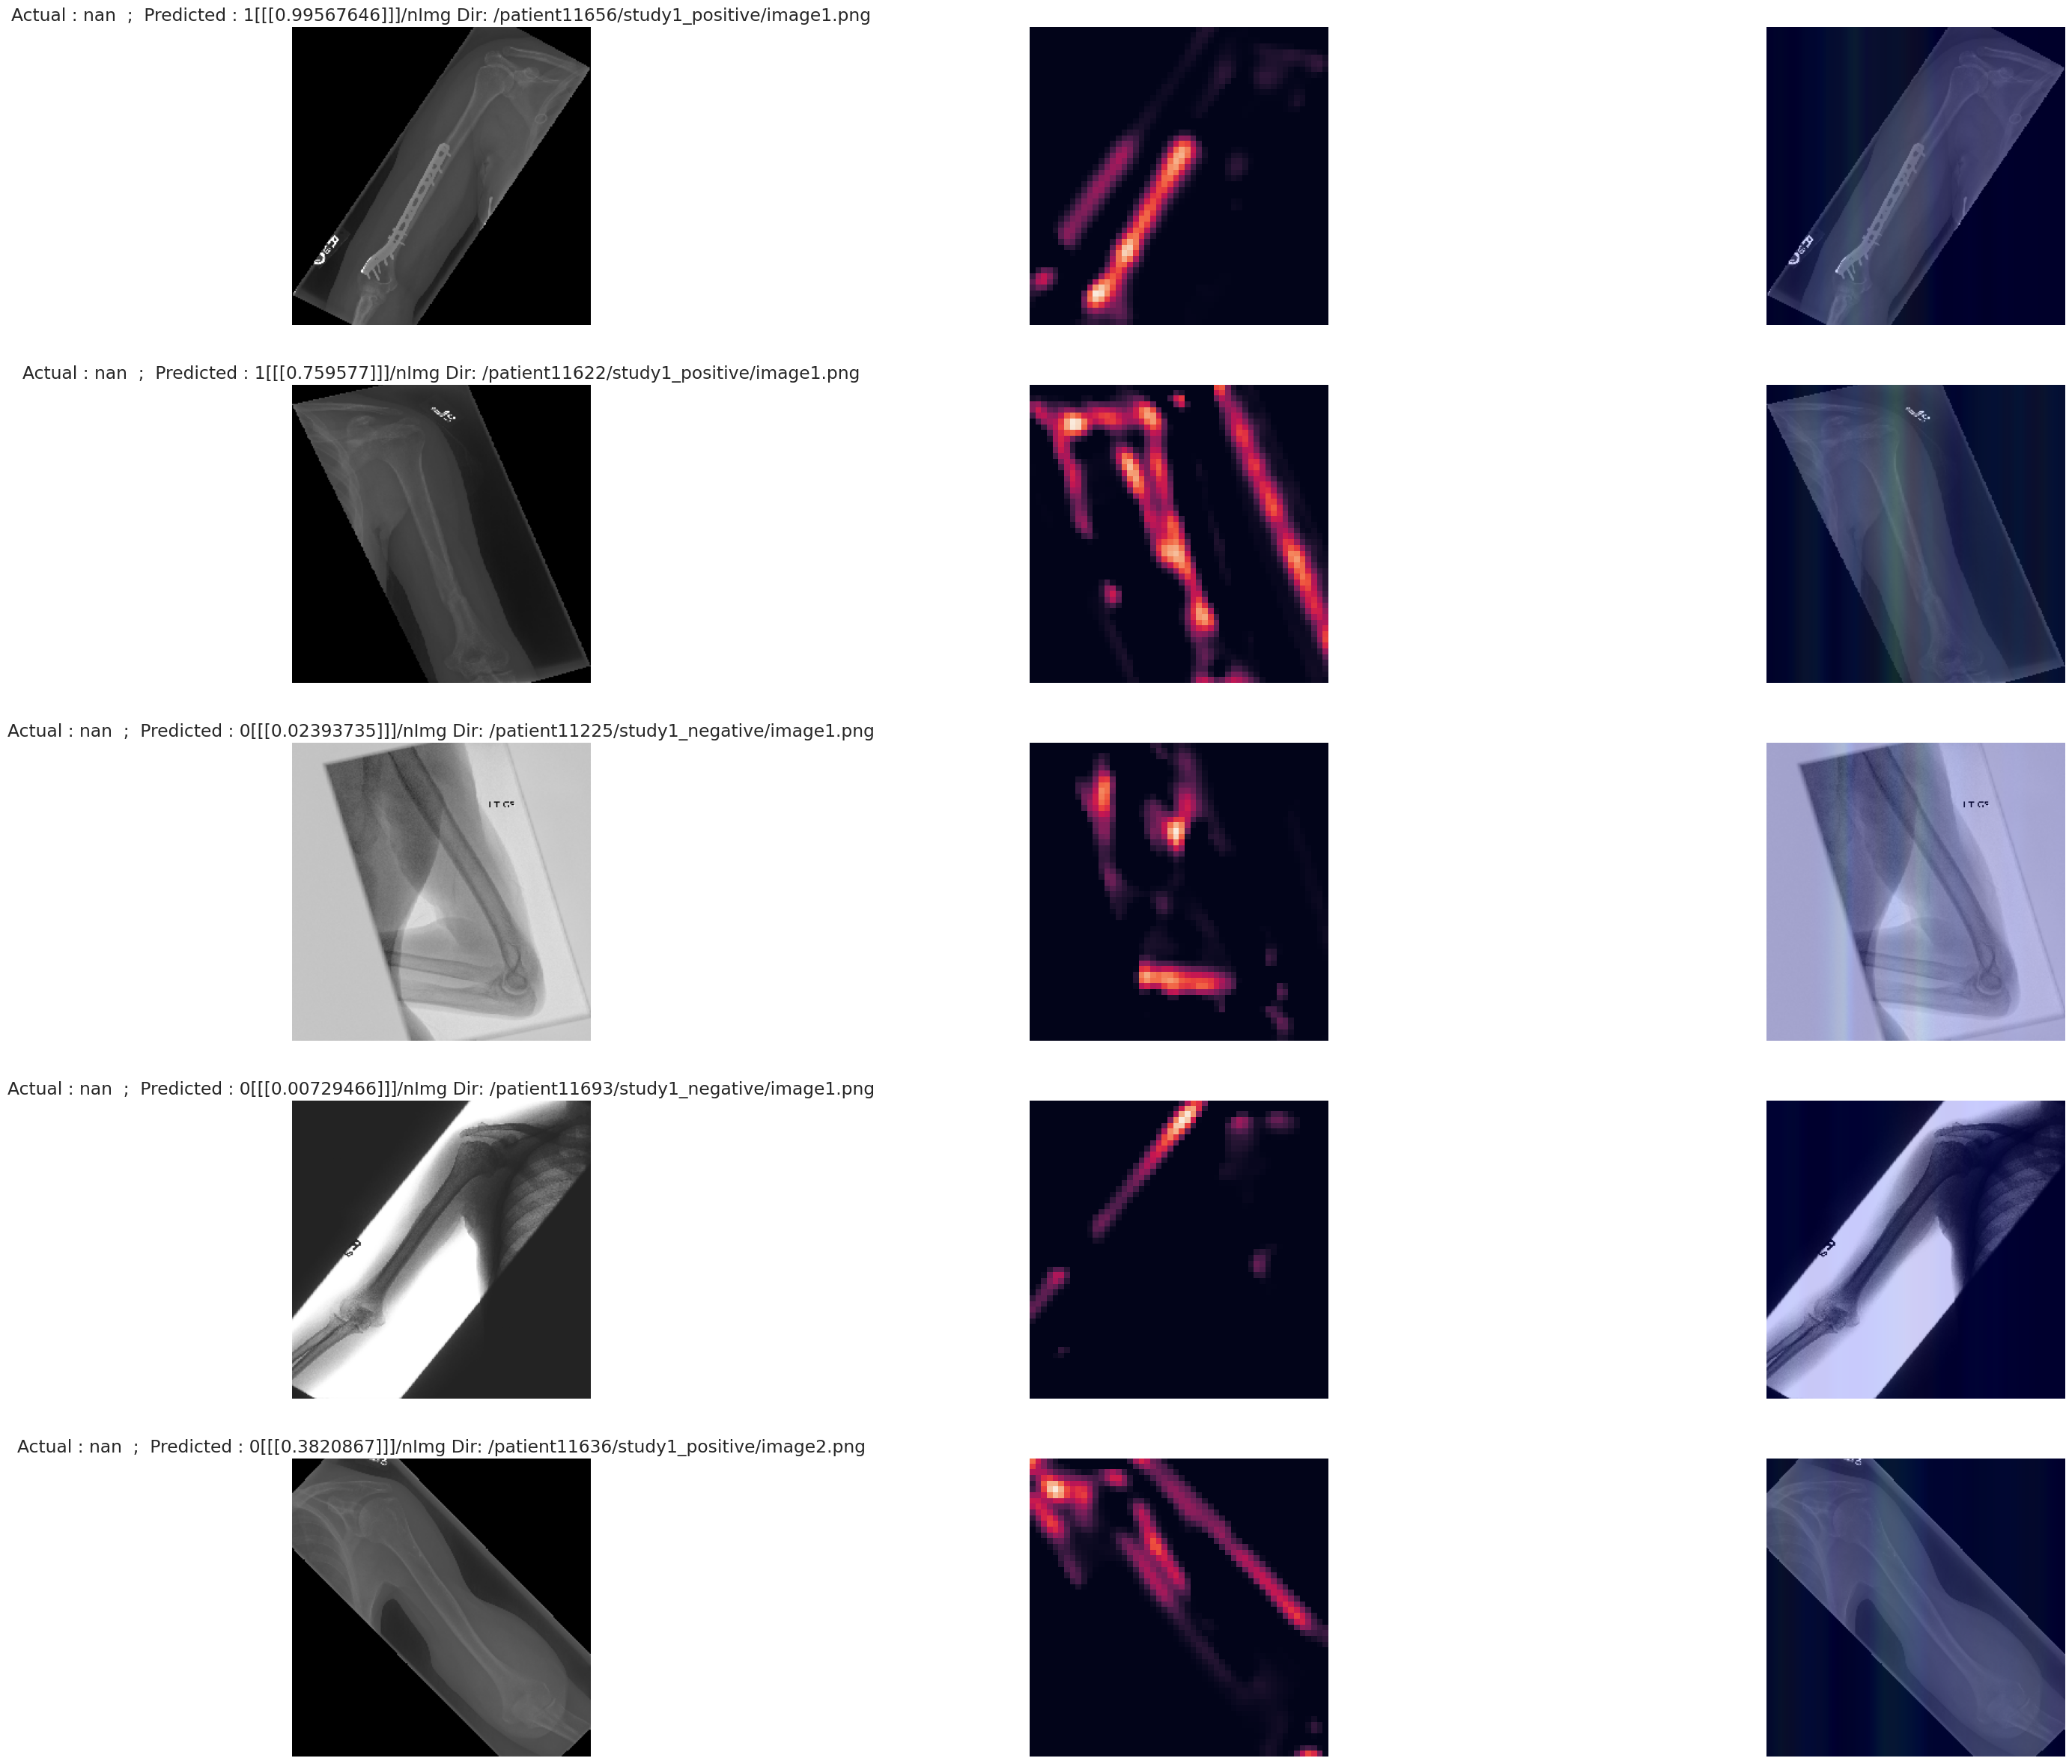

In [37]:
study_type = "XR_HUMERUS"
grad_cam_vis(validation_csv, study_type, preprocessing_function, model, last_conv_layer_name , classifier_layer_names, number=5,size_tuple=(image_height,image_width) ) #None,tp,tn,fp,fn



1/1 [==============================] - 0s 20ms/step


<ipython-input-35-de8453d1f990>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cma.get_cmap("jet")


1/1 [==============================] - 0s 20ms/step


<ipython-input-35-de8453d1f990>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cma.get_cmap("jet")


1/1 [==============================] - 0s 20ms/step


<ipython-input-35-de8453d1f990>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cma.get_cmap("jet")


1/1 [==============================] - 0s 22ms/step


<ipython-input-35-de8453d1f990>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cma.get_cmap("jet")
<ipython-input-35-de8453d1f990>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cma.get_cmap("jet")


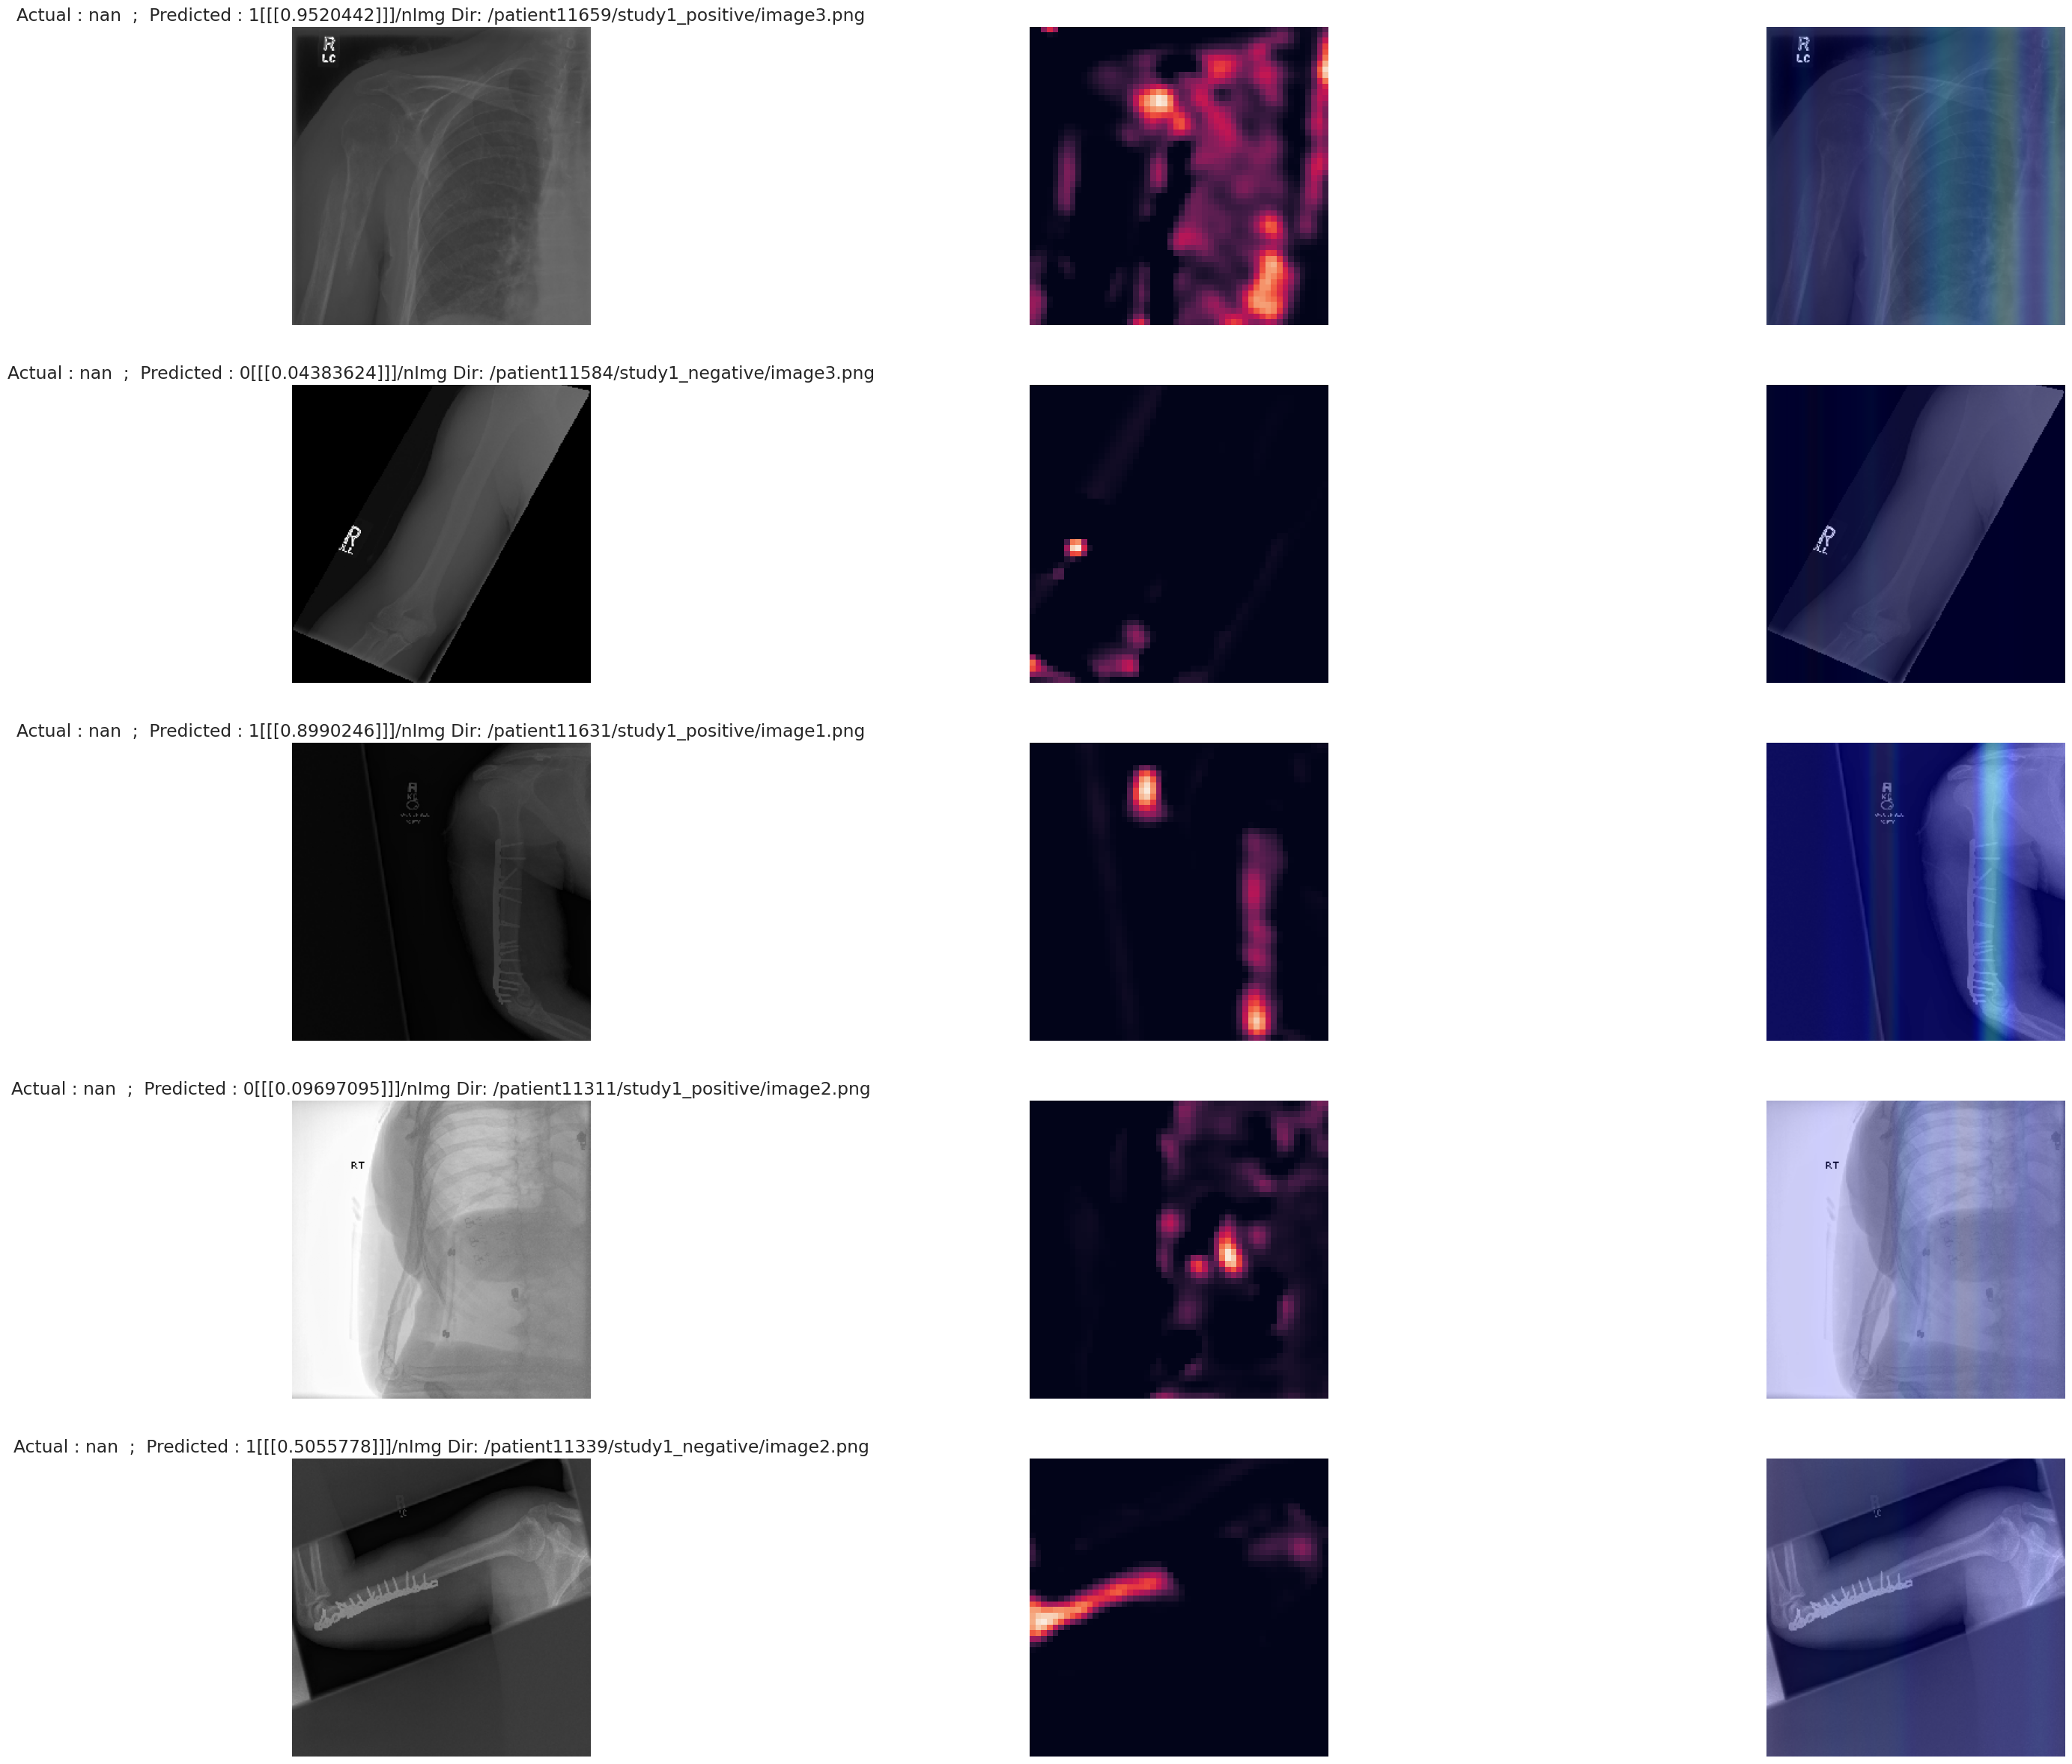

In [38]:
study_type = "XR_HUMERUS"
grad_cam_vis(validation_csv, study_type, preprocessing_function, model, last_conv_layer_name , classifier_layer_names, number=5,size_tuple=(image_height,image_width) ) #None,tp,tn,fp,fn

1/1 [==============================] - 0s 22ms/step


<ipython-input-35-de8453d1f990>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cma.get_cmap("jet")


1/1 [==============================] - 0s 21ms/step


<ipython-input-35-de8453d1f990>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cma.get_cmap("jet")


1/1 [==============================] - 0s 20ms/step


<ipython-input-35-de8453d1f990>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cma.get_cmap("jet")


1/1 [==============================] - 0s 21ms/step


<ipython-input-35-de8453d1f990>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cma.get_cmap("jet")
<ipython-input-35-de8453d1f990>:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cma.get_cmap("jet")


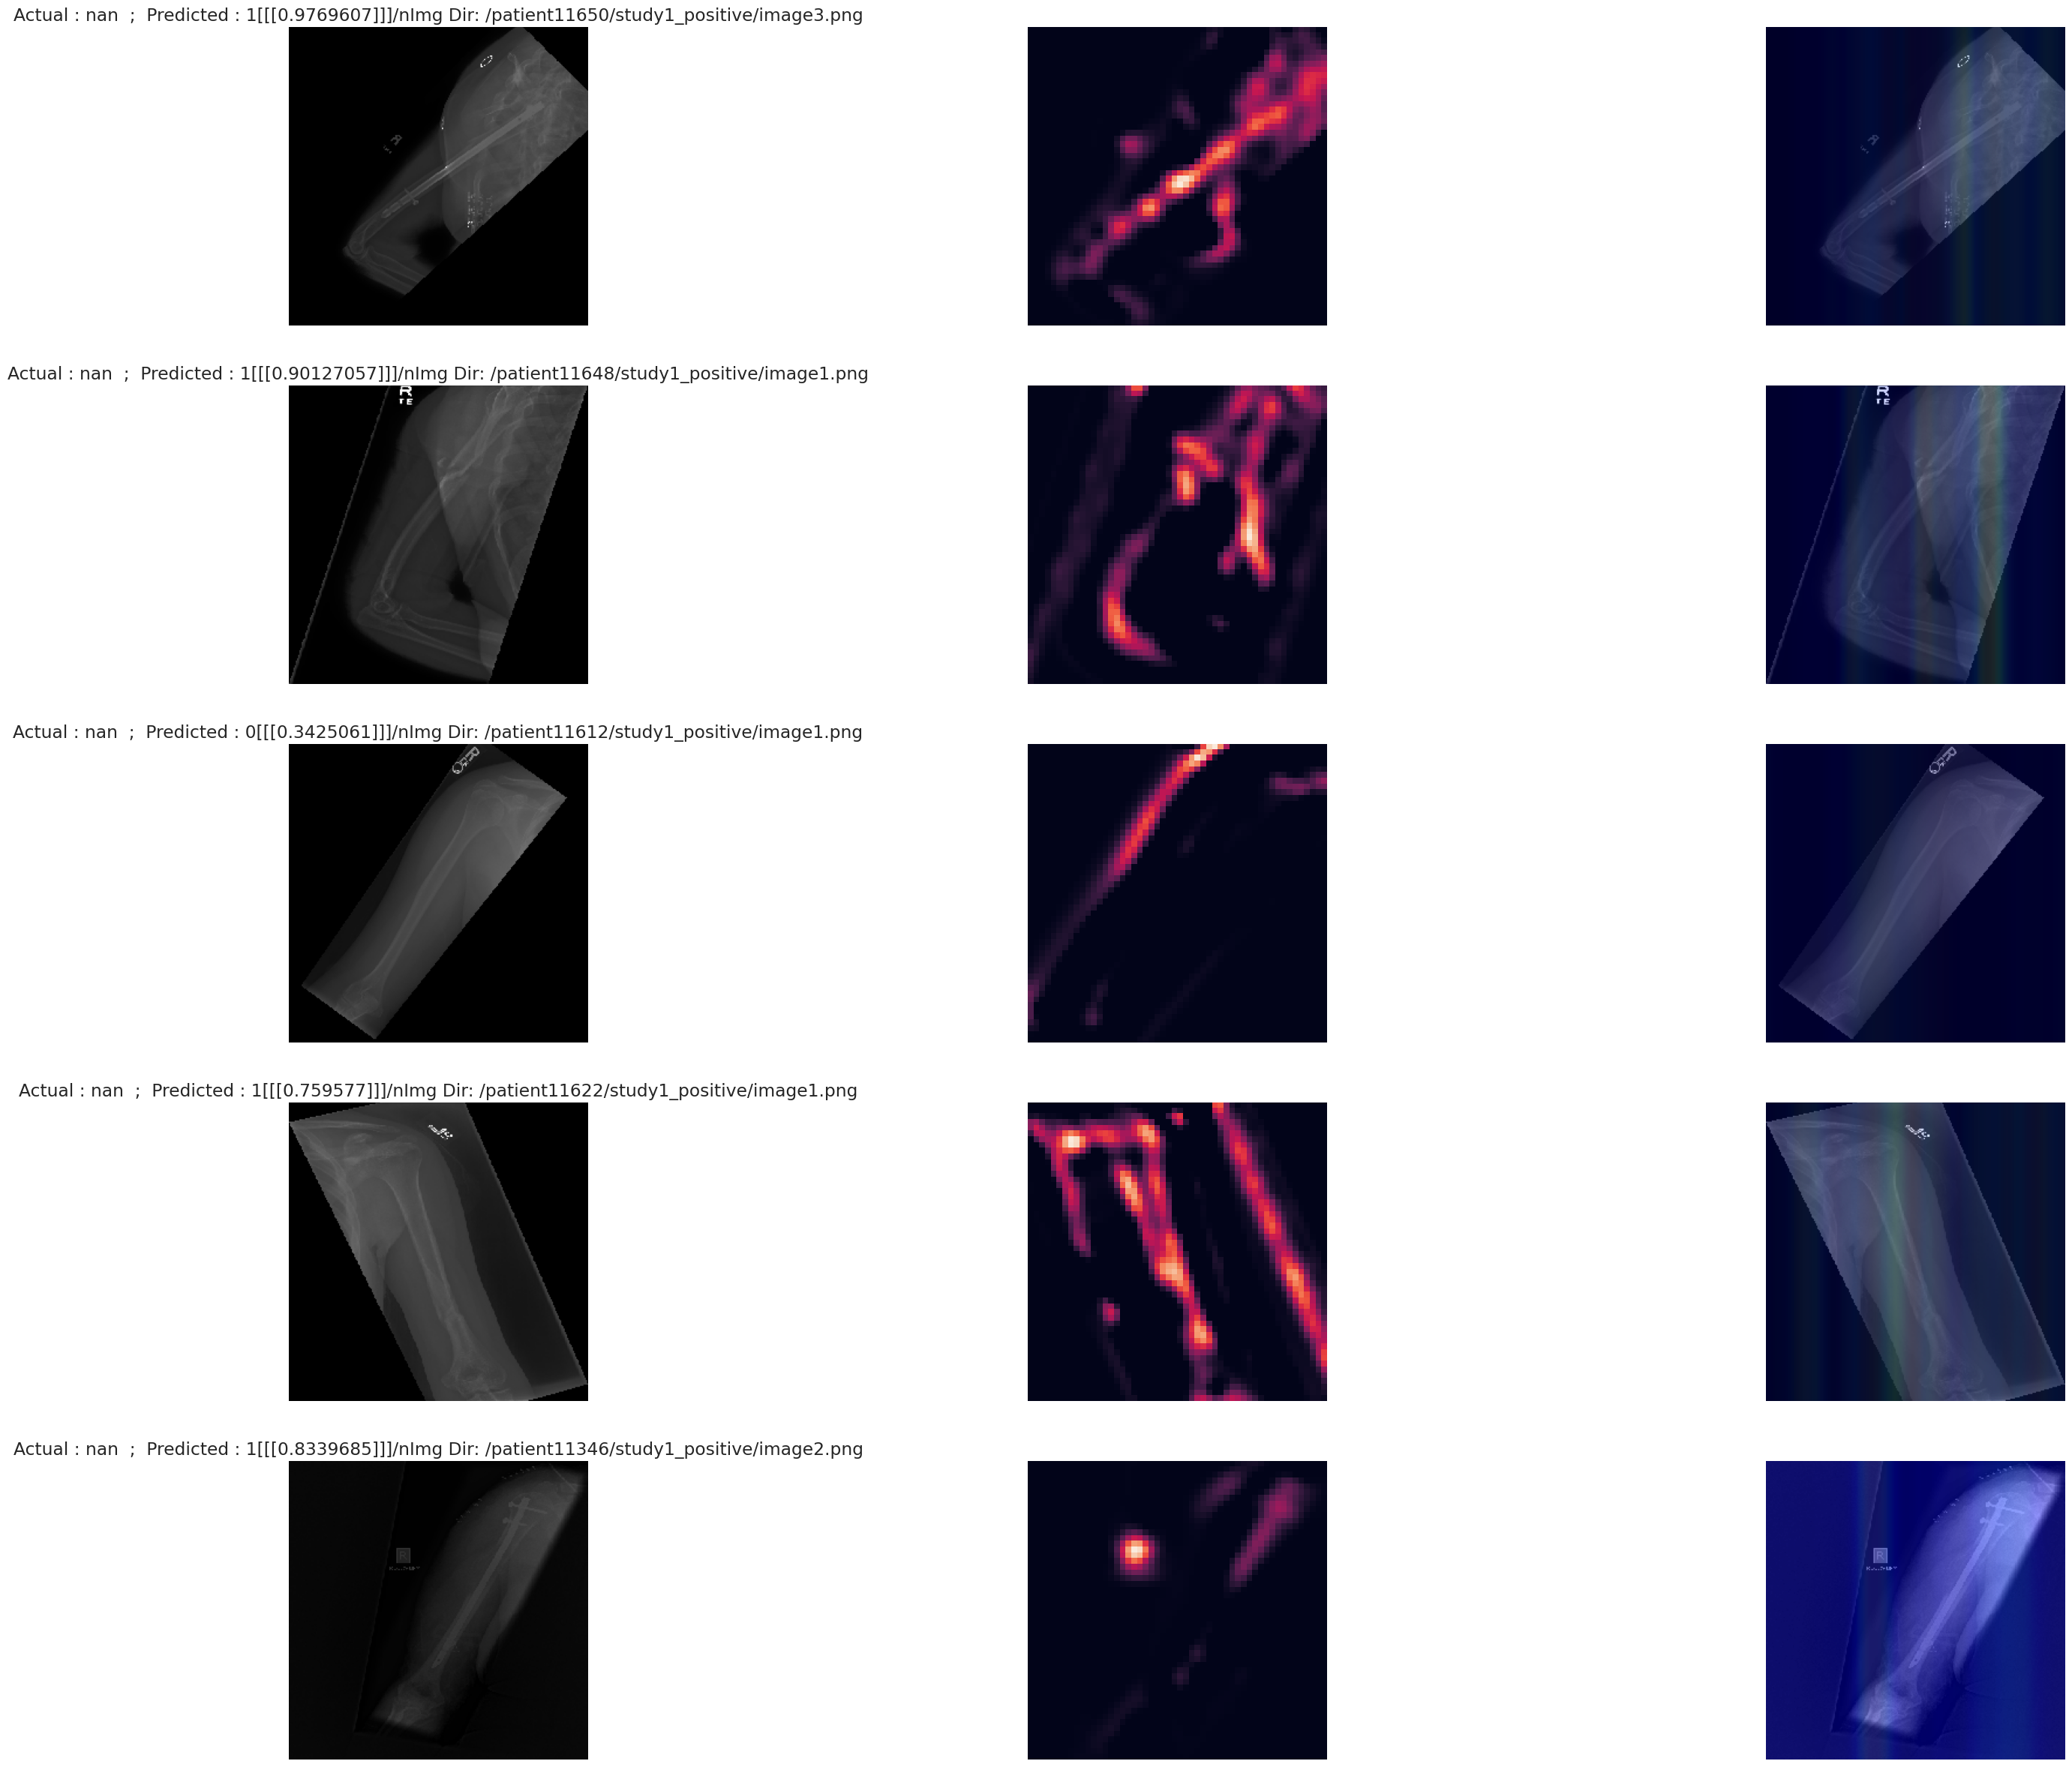

In [39]:
study_type = "XR_HUMERUS"
grad_cam_vis(validation_csv, study_type, preprocessing_function, model, last_conv_layer_name , classifier_layer_names, number=5,size_tuple=(image_height,image_width) ) #None,tp,tn,fp,fn

